In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os

In [2]:
device = 'cpu:0' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [3]:
batch_size = 64
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 0.1 # априорная дисперсия
epoch_num = 25 #количество эпох
lamb = [0.1, 1,  10, 100]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5


lam_hidden_num = 50
lambda_sample_num = 5
path_to_save = 'saved'


In [4]:
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


0it [00:00, ?it/s]

9920512it [00:01, 5832232.54it/s]                             


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 85174.14it/s]                            
0it [00:00, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


1654784it [00:01, 1550553.96it/s]                           
0it [00:00, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


8192it [00:00, 31663.50it/s]            

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...
Done!


In [6]:
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_, device=device)) # параметры средних
        t.nn.init.xavier_uniform(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_, device = device)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_, device=device)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_, device=device) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean, t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  t.exp(self.log_sigma_b))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

In [7]:
class LowRankNet(nn.Module):
    def __init__(self, size, hidden, gain_const = 1.0, gain_lamb = 1.0,
                 gain_lowrank = .0001,  act= F.relu):    
        nn.Module.__init__(self)        
        self.w = nn.Linear(1, hidden).to(device)
        t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
        # проверка на вектор или матрица
        if isinstance(size, tuple) and len(size) == 2: # если сайз неизменяемый список и его длина 2
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1,device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            self.w_d = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            
        else:
            self.w_a1 = nn.Linear(hidden, self.in_).to(device)
            t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
            
            self.w_a2 = nn.Linear(hidden, self.out_).to(device)
            t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
            
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            
            
    def forward(self, lam):
        h = self.act(self.w(self.one * lam))        
        if self.diagonal:
            return self.const + self.w_d(h)
        else:
            a1 = self.w_a1(h)
            a2 = self.w_a2(h)
         
            return self.const +  t.matmul(a1.view(-1, 1), a2.view(1, -1))

        
class LinearApprNet(nn.Module):
    def __init__(self, size,  gain_const = 1.0, gain_const2 = 0.000001,  act= lambda x: x):    
        nn.Module.__init__(self)        
        if isinstance(size, tuple) and len(size) == 2:
            self.in_, self.out_ = size
            self.diagonal = False
        else:
            self.out_ = size
            self.diagonal = True
            
        
        self.one = t.ones(1, device=device) # для упрощения работы с лямбдой. Костыль, можно сделать проще
        self.act = act
        
        if self.diagonal:
            # независимая от параметра lambda часть
            self.const = nn.Parameter(t.randn(self.out_, device=device)) 
            self.const2 = nn.Parameter(t.ones(self.out_, device=device) * gain_const2) 
            
            
        else:
            self.const = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const,  gain_const)
            self.const2 = nn.Parameter(t.randn(self.in_, self.out_, device=device)) 
            t.nn.init.xavier_uniform(self.const2,  gain_const2)
            
            
    def forward(self, lam):        
        if self.diagonal:
            return self.const + self.const2 * lam
        else:
            return self.const + self.const2 * lam 

        
class VarLayerLowRank(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LowRankNet((in_, out_), lam_hidden_num) # параметры средних            
        self.log_sigma = LowRankNet((in_, out_), lam_hidden_num) # логарифм дисперсии
        self.mean_b = LowRankNet( out_, lam_hidden_num) # то же самое для свободного коэффициента
        self.log_sigma_b = LowRankNet( out_, lam_hidden_num)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self,x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    

class VarLayerLinearAppr(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = LinearApprNet((in_, out_)) # параметры средних            
        self.log_sigma = LinearApprNet((in_, out_)) # логарифм дисперсии
        self.mean_b = LinearApprNet( out_) # то же самое для свободного коэффициента
        self.log_sigma_b = LinearApprNet( out_)
     
        self.log_sigma.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma.const.data+= init_log_sigma
     
        self.log_sigma_b.const.data*= 0 # забьем константу нужными нам значениями
        self.log_sigma_b.const.data+= init_log_sigma
        
        
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        
    def forward(self, x, l):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
            self.eps_b = t.distributions.Normal(self.mean_b(l), t.exp(self.log_sigma_b(l)))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean(l) 
            b = self.mean_b(l)
            
        # функция активации 
        return self.act(t.matmul(x, w)+b)

    def KLD(self, l):        
        # подсчет дивергенции
        size = self.in_, self.out_
        out = self.out_
        self.eps_w = t.distributions.Normal(self.mean(l), t.exp(self.log_sigma(l)))
        self.eps_b = t.distributions.Normal(self.mean_b(l),  t.exp(self.log_sigma_b(l)))
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), t.ones(size, device=device)*prior_sigma)
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), t.ones(out, device=device)*prior_sigma)                
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2    

In [8]:
class VarSeqNet(nn.Sequential):    
    # класс-обертка на случай, если у нас многослойная нейронная сеть
    def KLD(self, lam = None):
        k = 0
        for l in self: 
            if lam is None:
                k+=l.KLD()
            else:
                k+=l.KLD(lam)
                
        return k
    
    def forward(self, x, lam = None):
        if lam is None:
            for l in self:
                x = l(x)
            return x
        else:
            for l in self:
                x = l(x, lam)
            return x
    


In [9]:
def train_batches(net, loss_fn, optimizer, lam, label):
    tq = tqdm.tqdm(train_loader)
    losses = []
    for x,y in tq:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0
        if lam is None:
            for _ in range(lambda_sample_num):  
                p = t.rand(1).to(device)*3 -1
                lam_param = 10**p[0]
                
                #t.rand(1).to(device)[0]*100.0                  
                out = net(x, lam_param/100.0)
                loss = loss + loss_fn(out, y)/lambda_sample_num
                loss += net.KLD(lam_param/100.0)*lam_param/len(train_data)/lambda_sample_num
                losses+=[loss.cpu().detach().numpy()]
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
        else:
            out = net(x)
            loss = loss + loss_fn(out, y)
            loss += net.KLD()*lam/len(train_data)
            losses+=[loss.cpu().detach().numpy()]
        tq.set_description(label+str(np.mean(losses)))
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()

In [ ]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, start)))

<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
lambda 0.1, epoch 6: 0.26579237:  70%|██████▉   | 652/938 [00:07<00:03, 84.72it/s]

In [28]:
for mode in ['lowrank', 'linear']:
    t.manual_seed(0)
    for start in range(start_num): 
        if mode == 'lowrank':
            net = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
        else:
            net = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
            
        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = '{}, epoch {}: '.format(mode, e)                
            train_batches(net, loss_fn, optim, None, label)
        t.save(net.state_dict(), os.path.join(path_to_save, '{}_start_{}.cpk'.format(mode, start)))

<ipython-input-11-cd1a223d91d2>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-11-cd1a223d91d2>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
lowrank, epoch 24: 0.53450024: 100%|██████████| 938/938 [00:43<00:00, 21.55it/s]
<ipy

In [29]:
def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval()
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc


# будем удалять по 10% от модели и смотреть качество
def delete_10(net):
    acc_delete = []
    mu = net[0].mean
    sigma = t.exp(2*net[0].log_sigma)
    prune_coef = (mu**2/sigma).cpu().detach().numpy()    
    sorted_coefs = np.sort(prune_coef.flatten())
    mu2 = net[1].mean
    sigma2 = t.exp(2*net[1].log_sigma)
    prune_coef2 = (mu2**2/sigma2).cpu().detach().numpy()    
    sorted_coefs2 = np.sort(prune_coef2.flatten())
    
    
    for j in range(10):
        
        ids = (prune_coef <= sorted_coefs[round(j/10*len(sorted_coefs))]) 
        net[0].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))
        
        ids2 = (prune_coef2 <= sorted_coefs2[round(j/10*len(sorted_coefs2))]) 
        net[1].mean.data*=(1-t.tensor(ids2*1.0, device=device, dtype=t.float))
        
        print ('nonzero params: ', (abs(net[0].mean)>0).float().mean())
        acc_delete.append(test_acc(net))
    return acc_delete    


In [18]:
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


In [21]:
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join('saved/', 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(delete_10(net))

0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

In [22]:
import json
with open('results_var.json','w') as out:
    out.write(json.dumps(lam_results))

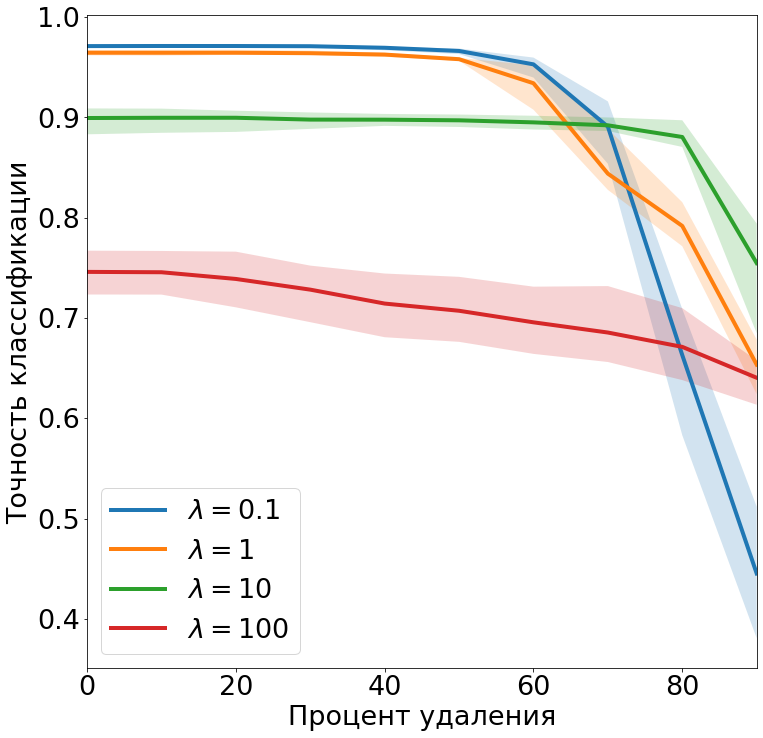

In [23]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [42]:
def net_copy(net, new_net, lam):
    lam_param = lam/100.0
    for j in range(0, 2): # бежим по слоям        
        new_net[j].mean.data*=0
        new_net[j].mean.data+=net[j].mean(lam_param)
        new_net[j].mean_b.data*=0
        new_net[j].mean_b.data+=net[j].mean_b(lam_param)
        new_net[j].log_sigma.data*=0
        new_net[j].log_sigma.data+=net[j].log_sigma(lam_param)
        new_net[j].log_sigma_b.data*=0
        new_net[j].log_sigma_b.data+=net[j].log_sigma_b(lam_param)
    


In [43]:
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))
        
        net_copy(hnet, net, lam)
        lam_results[lam].append(delete_10(net))

<ipython-input-11-cd1a223d91d2>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-11-cd1a223d91d2>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now depreca

0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

In [44]:
import json
with open('results_lowrank.json','w') as out:
    out.write(json.dumps(lam_results))

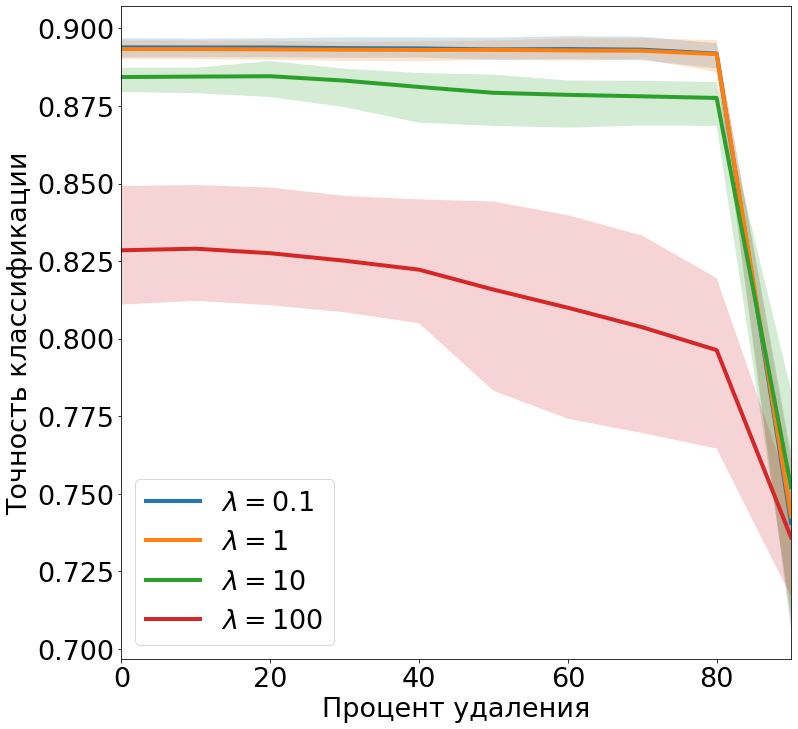

In [45]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [46]:
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))
        
        net_copy(hnet, net, lam)
        lam_results[lam].append(delete_10(net))

<ipython-input-11-cd1a223d91d2>:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  gain_const2)
<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

In [47]:
import json
with open('results_linear.json','w') as out:
    out.write(json.dumps(lam_results))

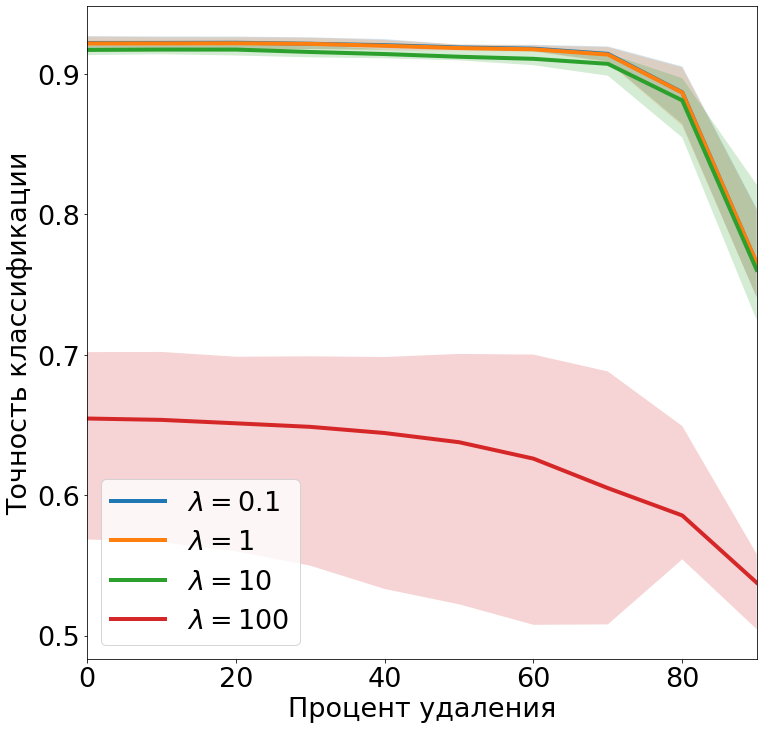

In [48]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [52]:
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
    
lam_results = {}
t.manual_seed(0)
for lam in lamb:    
    lam_results[lam] = []
    for s in range(start_num):
        
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        label = 'finetune lowrank, lam:{} '.format(lam)                
        train_batches(net, loss_fn, optim, lam, label)        
        lam_results[lam].append(delete_10(net))
        

<ipython-input-11-cd1a223d91d2>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-11-cd1a223d91d2>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_d.weight, gain_lowrank)
<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now depreca

nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.32018197: 100%|██████████| 938/938 [00:10<00:00, 88.67it/s]


nonzero params:  tensor(0.9947, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.31081945: 100%|██████████| 938/938 [00:09<00:00, 94.78it/s]


nonzero params:  tensor(0.9996, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.29516327: 100%|██████████| 938/938 [00:09<00:00, 94.49it/s]


nonzero params:  tensor(0.9990, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:0.1 0.30646956: 100%|██████████| 938/938 [00:09<00:00, 96.00it/s]


nonzero params:  tensor(0.9959, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 0.39244556: 100%|██████████| 938/938 [00:09<00:00, 96.87it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 0.39470667: 100%|██████████| 938/938 [00:09<00:00, 96.25it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 0.38585204: 100%|██████████| 938/938 [00:09<00:00, 95.25it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 0.3706034: 100%|██████████| 938/938 [00:10<00:00, 91.90it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:1 0.3784304: 100%|██████████| 938/938 [00:09<00:00, 94.75it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 0.5832895: 100%|██████████| 938/938 [00:09<00:00, 95.09it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 0.5848494: 100%|██████████| 938/938 [00:10<00:00, 89.75it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 0.5876159: 100%|██████████| 938/938 [00:10<00:00, 92.95it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 0.57798785: 100%|██████████| 938/938 [00:09<00:00, 94.94it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:10 0.58795065: 100%|██████████| 938/938 [00:10<00:00, 91.65it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3999, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 1.4680902: 100%|██████████| 938/938 [00:10<00:00, 93.20it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 1.4825109: 100%|██████████| 938/938 [00:10<00:00, 91.56it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 1.4725662: 100%|██████████| 938/938 [00:10<00:00, 86.56it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 1.4849569: 100%|██████████| 938/938 [00:10<00:00, 92.64it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune lowrank, lam:100 1.464507: 100%|██████████| 938/938 [00:10<00:00, 91.30it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


In [53]:
import json
with open('results_lowrank_finetune.json','w') as out:
    out.write(json.dumps(lam_results))

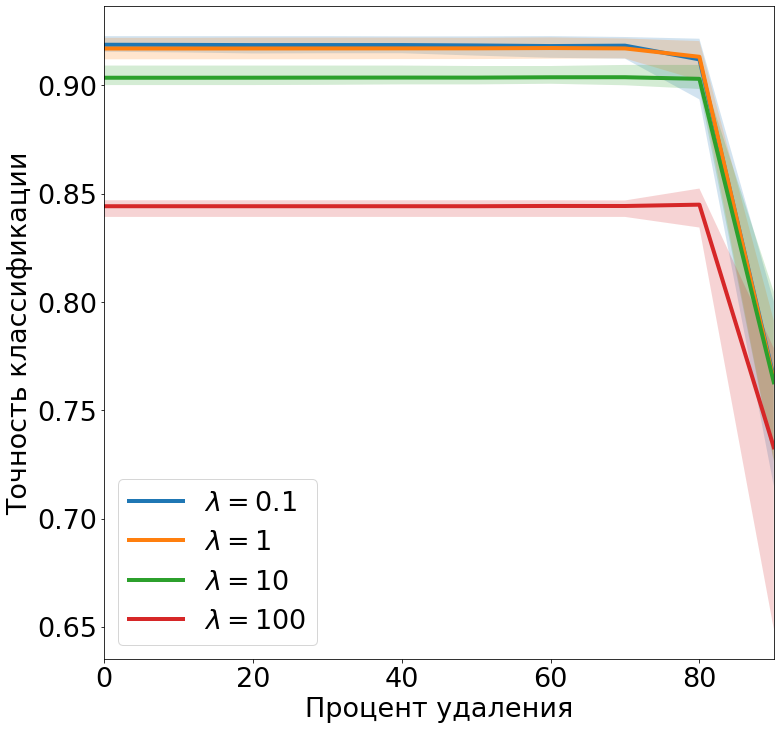

In [54]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [55]:
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
net = net.to(device)
t.manual_seed(0)    
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        label = 'finetune linear, lam:{} '.format(lam)                
        train_batches(net, loss_fn, optim, lam, label)        
        lam_results[lam].append(delete_10(net))
        

<ipython-input-11-cd1a223d91d2>:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  gain_const2)
<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
finetune linear, lam:0.1 0.37339014: 100%|██████████| 938/938 [00:10<00:00, 89.09it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.23804852: 100%|██████████| 938/938 [00:10<00:00, 91.45it/s]


nonzero params:  tensor(0.9991, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.23159908: 100%|██████████| 938/938 [00:10<00:00, 91.33it/s]


nonzero params:  tensor(0.9981, device='cuda:0')
nonzero params:  tensor(0.8998, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.23088959: 100%|██████████| 938/938 [00:09<00:00, 94.57it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:0.1 0.22816923: 100%|██████████| 938/938 [00:09<00:00, 95.40it/s]


nonzero params:  tensor(0.9976, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.28225997: 100%|██████████| 938/938 [00:10<00:00, 91.59it/s]


nonzero params:  tensor(0.9987, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.28983936: 100%|██████████| 938/938 [00:09<00:00, 94.01it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.6998, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.2852354: 100%|██████████| 938/938 [00:10<00:00, 90.14it/s] 


nonzero params:  tensor(0.9992, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.28301293: 100%|██████████| 938/938 [00:10<00:00, 88.58it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.8996, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:1 0.2813802: 100%|██████████| 938/938 [00:10<00:00, 91.29it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.6998, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.588037: 100%|██████████| 938/938 [00:10<00:00, 93.36it/s]  


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.8999, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3997, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.5894001: 100%|██████████| 938/938 [00:10<00:00, 93.38it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.5996, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.5895236: 100%|██████████| 938/938 [00:10<00:00, 93.43it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.5866254: 100%|██████████| 938/938 [00:10<00:00, 92.75it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.7989, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3994, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:10 0.5881078: 100%|██████████| 938/938 [00:09<00:00, 95.47it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 1.535793: 100%|██████████| 938/938 [00:10<00:00, 91.23it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 1.540986: 100%|██████████| 938/938 [00:09<00:00, 93.93it/s] 


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.4998, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 1.5457824: 100%|██████████| 938/938 [00:09<00:00, 97.10it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.8989, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.3999, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 1.5315775: 100%|██████████| 938/938 [00:10<00:00, 93.14it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.5998, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


finetune linear, lam:100 1.5430539: 100%|██████████| 938/938 [00:09<00:00, 94.67it/s]


nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')


In [56]:
import json
with open('results_linear_finetune.json','w') as out:
    out.write(json.dumps(lam_results))

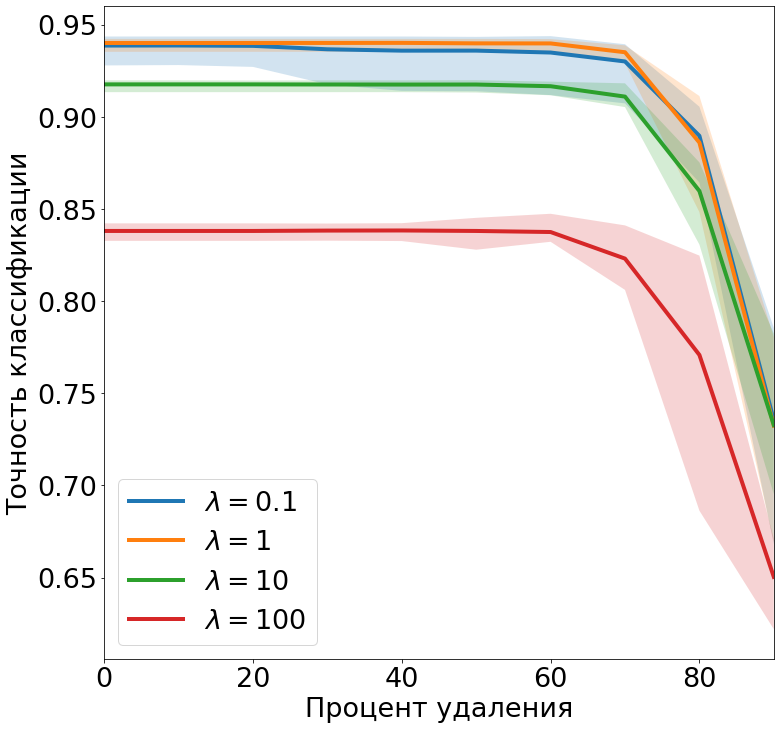

In [57]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [75]:
for lam in lamb:
    t.manual_seed(0) 
    for start in range(start_num):                    
            net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)                        
            label = 'lambda {} '.format(lam)                
            train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, start)))

<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
lambda 100 21.16245: 100%|██████████| 938/938 [00:10<00:00, 87.66it/s] 


In [76]:
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join('saved/', 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(delete_10(net))

0.1 0
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 1
nonzero params:  tensor(1.0000, device='cuda:0')
nonzero params:  tensor(0.9000, device='cuda:0')
nonzero params:  tensor(0.8000, device='cuda:0')
nonzero params:  tensor(0.7000, device='cuda:0')
nonzero params:  tensor(0.6000, device='cuda:0')
nonzero params:  tensor(0.5000, device='cuda:0')
nonzero params:  tensor(0.4000, device='cuda:0')
nonzero params:  tensor(0.3000, device='cuda:0')
nonzero params:  tensor(0.2000, device='cuda:0')
nonzero params:  tensor(0.1000, device='cuda:0')
0.1 2
no

In [77]:
import json
with open('results_1e.json','w') as out:
    out.write(json.dumps(lam_results))

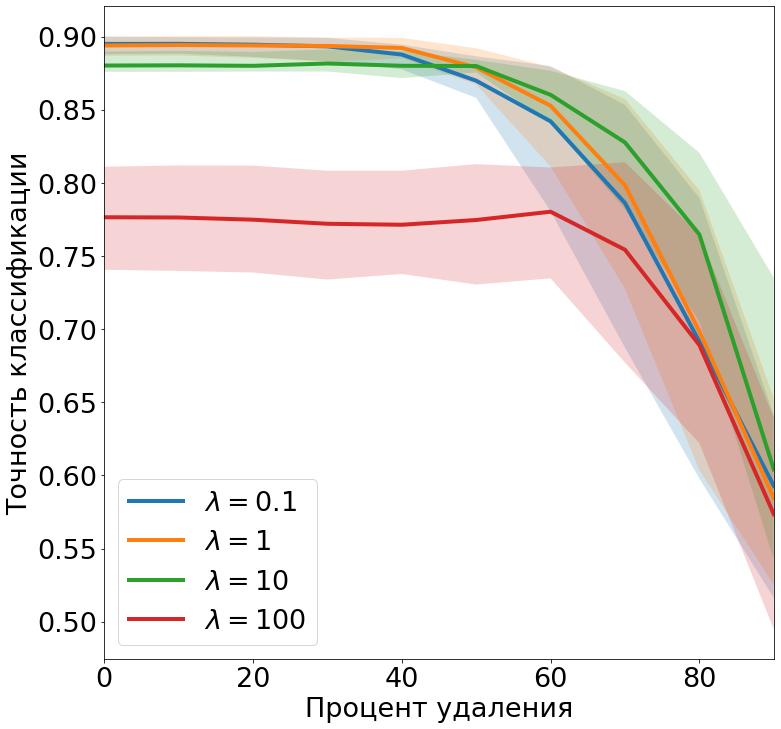

In [78]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('Hypernet_lowrank3 + 1')
#plt.show()


In [79]:
#calculating accuracy
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
    for lam in lamb:
        lam = str(lam)
        print (lam, np.mean(data[lam][0]), np.std(data[lam][0]))
    print()

mode: results_var
0.1 0.8768600000000001 0.180850502902259
1 0.9015699999999999 0.1015020103249192
10 0.8674 0.061154280308086374
100 0.73031 0.037807312784698156

mode: results_1e
0.1 0.8168199999999999 0.11510535000598365
1 0.81986 0.11094416794045553
10 0.83477 0.08741724143439898
100 0.78924 0.05191011847414722

mode: results_lowrank
0.1 0.87719 0.03946480584014065
1 0.8766499999999999 0.039650907934119226
10 0.8746599999999999 0.03046066972343189
100 0.83124 0.03248714207190283

mode: results_linear
0.1 0.9006799999999998 0.0417290498334194
1 0.9002100000000001 0.0418596810785749
10 0.8921799999999998 0.041974558961351806
100 0.53857 0.024994241336755953

mode: results_lowrank_finetune
0.1 0.90262 0.03416459570959386
1 0.90167 0.037342657912901714
10 0.8887600000000001 0.035687818650066025
100 0.83902 0.02012231597008657

mode: results_linear_finetune
0.1 0.9010400000000001 0.04101290528601943
1 0.91456 0.056987282791865074
10 0.8953800000000001 0.0457794451692023
100 0.8062699999

In [80]:
#calculating stability
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
        
    for lam in lamb:
        lam = str(lam)
        v_0 = np.array(data[lam])[:,0]
        v_last = np.array(data[lam])[:,-1]
        
        stab = v_0/v_last
        print (lam, np.mean(stab), np.std(stab))
    print()

mode: results_var
0.1 2.2095718406753138 0.2540762518381766
1 1.4768410313948264 0.03876415389661146
10 1.1943260860289477 0.05432335063576823
100 1.1655268629230346 0.041839688354412444

mode: results_1e
0.1 1.5185162146863513 0.12024690253702998
1 1.5372498646770185 0.11219062902901537
10 1.4739058696158518 0.15075498492006287
100 1.3628170603874603 0.12360810190146203

mode: results_lowrank
0.1 1.2080033648003554 0.036392145931447024
1 1.2039375357495192 0.03583030769565768
10 1.1771149074472835 0.0411980956603168
100 1.125795823134514 0.014758241950911407

mode: results_linear
0.1 1.206345194353315 0.04059851352997449
1 1.2054338775292013 0.039321262550000124
10 1.2084818282443863 0.05476608902095843
100 1.216403821971243 0.061170985544500525

mode: results_lowrank_finetune
0.1 1.2026498344131247 0.04651840951491279
1 1.2017604983236403 0.038063595869942624
10 1.1860341711973903 0.04623328301384698
100 1.1563848700493828 0.07275206194967425

mode: results_linear_finetune
0.1 1.2811

In [87]:
print ('ordinal model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):        
        net.load_state_dict(t.load(os.path.join('saved/', 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))                 
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
        

ordinal model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


0.1 9035.229504442215
1 24338.233991146088
10 56679.427070617676
100 128928.67107391357


In [90]:
print ('1e model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):        
        net.load_state_dict(t.load(os.path.join('saved/', 'var_1e_net_lam_{}_start_{}.cpk'.format(lam, s))))                 
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
        

1e model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


0.1 32788.8383392334
1 51832.86357688904
10 186124.63739395142
100 696240.5514717102


In [92]:
print ('lr model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
print ('lr ft model')
for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'lowrank_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)        
        train_batches(net, loss_fn, optim, lam, label)   
        
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]  
        
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
                

lr model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
<ipython-input-11-cd1a223d91d2>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w.weight, gain_lamb)
<ipython-input-11-cd1a223d91d2>:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a1.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.w_a2.weight, gain_lowrank)
<ipython-input-11-cd1a223d91d2>:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.i

0.1 24566.31489696503
1 30949.930117607117
10 56720.93189239502


lambda 100 0.4310196:   1%|          | 9/938 [00:00<00:10, 88.79it/s] 

100 166657.0206642151
lr ft model


lambda 100 0.5384838:   1%|          | 10/938 [00:00<00:10, 92.33it/s] 

0.1 19994.676700782777


lambda 100 0.98274064:   1%|          | 9/938 [00:00<00:10, 89.95it/s]

1 27220.746832847595


lambda 100 2.7311857:   1%|          | 10/938 [00:00<00:10, 91.06it/s]

10 55508.39735031128


lambda 100 2.3467298: 100%|██████████| 938/938 [00:10<00:00, 89.02it/s]


100 132758.4135055542


In [93]:
print ('linear model')
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x)).to(device)
hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)   

for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
print ('lr ft model')
for lam in lamb:
    lam_results[lam] = []
    k = []
    ll = []
    for s in range(start_num):     
        hnet.load_state_dict(t.load(os.path.join('saved/', 'linear_start_{}.cpk'.format(s))))        
        net_copy(hnet, net, lam)
        t.manual_seed(0)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)        
        train_batches(net, loss_fn, optim, lam, label)   
        
        k+= [net.KLD().cpu().detach().numpy()]
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            ll += [loss_fn(net(x), y).cpu().detach().numpy()]  
        
    print (lam, np.mean(ll)*len(train_data) + lam * np.mean(k))
            
                

linear model


<ipython-input-10-78e260db3aad>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
<ipython-input-11-cd1a223d91d2>:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  gain_const)
<ipython-input-11-cd1a223d91d2>:71: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  gain_const2)


0.1 24603.766856002807
1 28189.602142333984
10 58147.424964904785


lambda 100 0.47204697:   1%|          | 10/938 [00:00<00:09, 94.41it/s]

100 177139.47687149048
lr ft model


lambda 100 0.53265625:   1%|          | 10/938 [00:00<00:10, 92.13it/s]

0.1 20776.47305698395


lambda 100 1.0129691:   1%|          | 9/938 [00:00<00:10, 88.86it/s]

1 26262.995717048645


lambda 100 2.8632925:   1%|          | 10/938 [00:00<00:10, 92.44it/s]

10 57948.82610321045


lambda 100 2.3490837: 100%|██████████| 938/938 [00:10<00:00, 92.32it/s]


100 134340.96174240112


In [11]:
# количество оптимизаций параметров
# количество батчей * количество эпох * количество параметров, домноженное на количество элементов в lamb
net = VarSeqNet(VarLayer(784,  hidden_num), VarLayer(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in net.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
p_num_var = p_num

print ('ordinal', len(train_loader)*epoch_num*(p_num)*len(lamb))
print ('1e', len(train_loader)*p_num * len(lamb))

hnet = VarSeqNet(VarLayerLowRank(784,  hidden_num), VarLayerLowRank(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
    
print ('low rank', len(train_loader)*epoch_num*(p_num))
print ('low rank finetune', len(train_loader)*epoch_num*(p_num) + len(train_loader)*p_num_var)

hnet = VarSeqNet(VarLayerLinearAppr(784,  hidden_num), VarLayerLinearAppr(hidden_num, 10, act=lambda x:x))
p_num = 0
for p in hnet.parameters():
    size = p.size()
    if len(size)==1:
        p_num += size[0]
    elif len(size) == 2:
        p_num += np.prod(size)    
    
print ('linear', len(train_loader)*epoch_num*(p_num))
print ('linear fine tune', len(train_loader)*epoch_num*(p_num) + len(train_loader)*p_num_var)

ordinal 7458976000
1e 298359040
low rank 4165376600
low rank finetune 4239966360
linear 3729488000
linear fine tune 3804077760


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

In [ ]:
#new plots
for mode in ['results_var','results_1e', 'results_lowrank', 'results_linear', 'results_lowrank_finetune', 'results_linear_finetune']:
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        data = json.loads(inp.read())
    for lam in lamb:
        lam = str(lam)
        print (lam, np.mean(data[lam][0]), np.std(data[lam][0]))
    print()

mode: results_var
mode: results_1e
mode: results_lowrank
mode: results_lowrank_finetune
mode: results_linear
mode: results_linear_finetune


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


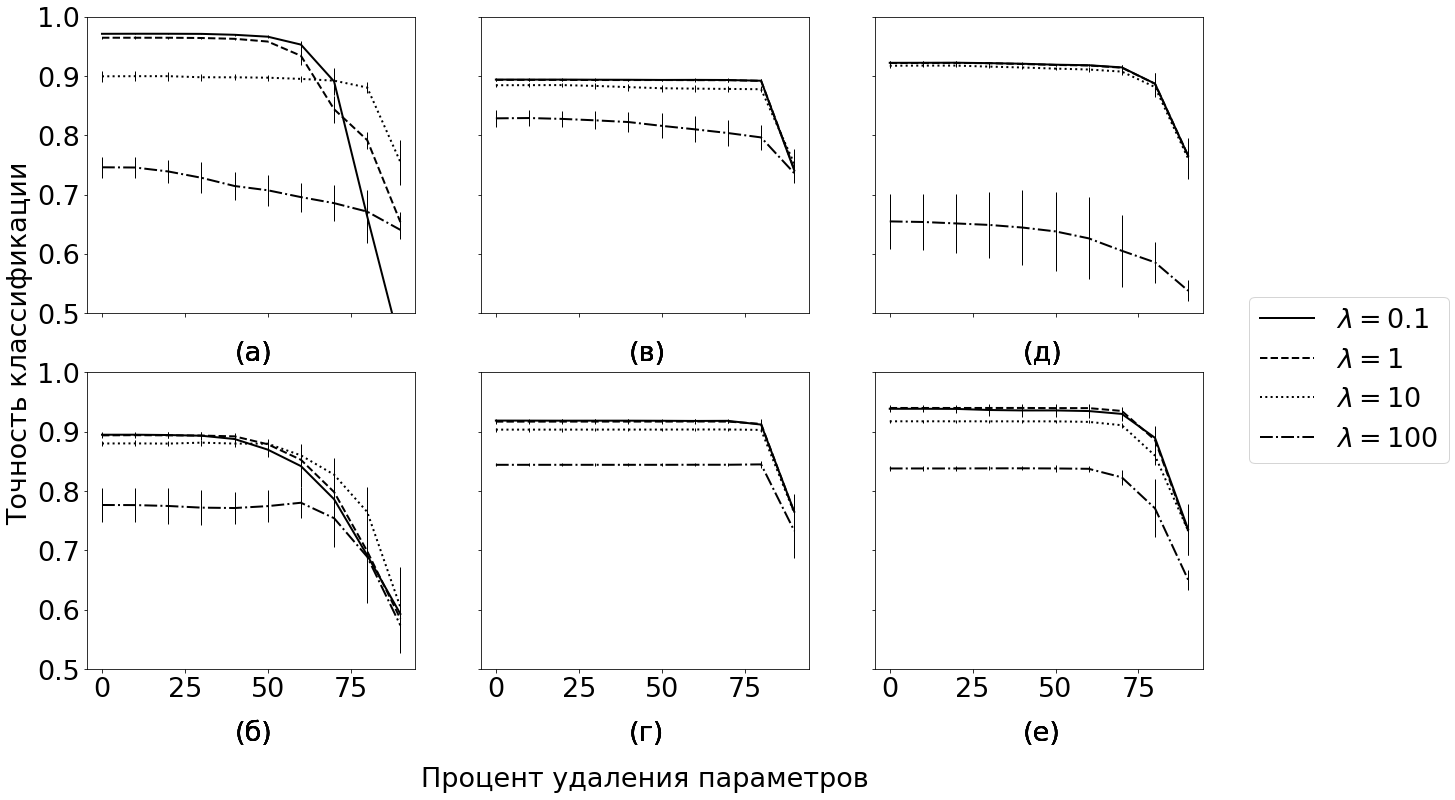

In [274]:
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
fig, axs = plt.subplots(2, 3)
coords = [(0,0), (1,0), (0,1), (1,1), (0,2), (1,2)]
titles = ['(а)', '(б)', '(в)', '(г)', '(д)', '(е)']
ls = {
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
roc = np.array([0,10,20,30,40,50,60,70,80,90])
for id, mode in enumerate(['results_var','results_1e', 'results_lowrank', 'results_lowrank_finetune', 'results_linear', 'results_linear_finetune']):
    print ('mode:', mode)
    with open(mode+'.json') as inp:
        lam_results = json.loads(inp.read())
    current_ax = axs[coords[id][0], coords[id][1]]
    p


    for lam in lamb:
        lam = str(lam)
        
        # вызываем plot и errorbar два раза:
        # (здесь это оказалось ненужным, но оставил на случай переделок:
        # если ошибки разных графиков сильно накладываются, их разносят небольшим сдвигом
        # а сами линии средних значений оставляют на месте)
        current_ax.errorbar(proc, np.mean(lam_results[lam], 0), 
                            yerr = np.std(lam_results[lam], 0), 
                            ls = ls[lam],  elinewidth=0, ecolor='black', color=(0,0,0,0), lw=1)
        current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[lam], c='k',
                       lw=2)
        
        #current_ax.set_title(titles[id], y=-0.05)
        if id in [1,3,5]:
            current_ax.text(40, .38, titles[id])
        else:
            current_ax.text(40, .42, titles[id])
        current_ax.set_ylim((0.5, 1.0))
        if id != 0 and id != 1:
            current_ax.set_yticklabels([])
        if id not in [1,3,5]:
            current_ax.set_xticklabels([])
        if id == 5:
            current_ax.legend(bbox_to_anchor=(1.1, 1.3))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления параметров', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
ax = plt.gca() 
ax.xaxis.set_label_coords(0.5, -0.15) 
#plt.autoscale(enable=True, axis='x', tight=False)
#fig.tight_layout()
plt.savefig('hypernets.eps', bbox_inches = 'tight')
#plt.show()



<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, **kwargs)>